**Importing Libraries**

In [436]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.utils import class_weight
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype, is_categorical_dtype, is_bool_dtype

**Loading the Data**

In [437]:
data = pd.read_csv('/content/amazon_phones_sales_dataset.csv')

**Cleaning the Data**

In [438]:
missing_values = data.isna()
missing_counts = data.isnull().sum()
missing_perc = (missing_counts / len(data)) * 100
print(missing_values.any().any())
print(missing_counts.sort_values())
print(missing_perc.sort_values())

True
discount                        0
brand                           0
price                           0
amazon_renewed                  0
best_seller_last_month          0
asin                           20
os                             66
storage                       109
name                          195
color                         221
screen_size                   240
wireless_carrier              271
ratings                       315
number_of_ratings             315
connectivity_technologies     512
cellular_technology           696
model                         981
ram                           993
resolution                   1655
battery_capacity             1693
battery_power                1894
cpu_speed                    2607
cpu_model                    3478
wireless_network             3585
charging_time                3639
dtype: int64
discount                      0.000000
brand                         0.000000
price                         0.000000
amazon_renewed 

In [439]:
sparse_cols = missing_perc[missing_perc > 60].index
data.drop(columns=sparse_cols, inplace=True)
print(f"\nDropped columns: {list(sparse_cols)}")
print("Shape after dropping sparse columns:", data.shape)


Dropped columns: ['cpu_model', 'charging_time', 'wireless_network', 'cpu_speed']
Shape after dropping sparse columns: (4250, 21)


In [440]:
row_thresh = data.shape[1] * 0.5
data.dropna(thresh=row_thresh, inplace=True)
print("Shape after dropping sparse rows:", data.shape)

Shape after dropping sparse rows: (4232, 21)


In [441]:
cols_to_clean = [
    'battery_capacity',
    'battery_power',
    'discount',
    'ram',
    'storage',
    'screen_size'
]

for col in cols_to_clean:
    if col in data.columns:
        data[col] = pd.to_numeric(
            data[col].astype(str).str.replace(r'[^0-9\.]', '', regex=True),
            errors='coerce'
        )

data['battery'] = data['battery_capacity'].combine_first(data['battery_power'])
data.drop(columns=['battery_capacity', 'battery_power'], inplace=True)

data.drop(columns=['resolution'], inplace=True)

In [442]:
num_cols = [
    'ram',
    'storage',
    'screen_size',
    'discount',
    'ratings',
    'number_of_ratings',
    'price',
    'battery'
]

medians = data[num_cols].median()
data[num_cols] = data[num_cols].fillna(medians)

cat_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()
data[cat_cols] = data[cat_cols].fillna('Unknown')

In [443]:
missing_values = data.isna()
print(missing_values.any().any())

False


In [444]:
data = data.drop_duplicates().reset_index(drop=True)

numeric_cols = [
    'price', 'discount', 'ratings', 'number_of_ratings',
    'ram', 'storage', 'screen_size', 'battery'
]

for col in numeric_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    data[col] = data[col].clip(lower=lower, upper=upper)

outliers_after = {
    col: ((data[col] < lower) | (data[col] > upper)).sum()
    for col in numeric_cols
}
print("Outliers remaining per column:", outliers_after)

print("Shape after capping outliers:", data.shape)

Outliers remaining per column: {'price': np.int64(4216), 'discount': np.int64(4216), 'ratings': np.int64(4216), 'number_of_ratings': np.int64(4216), 'ram': np.int64(4216), 'storage': np.int64(4216), 'screen_size': np.int64(4216), 'battery': np.int64(0)}
Shape after capping outliers: (4216, 19)


In [445]:
top_brands = data['brand'].value_counts().nlargest(5).index
data['brand_grouped'] = data['brand'].where(data['brand'].isin(top_brands), other='Other')

top_carriers = data['wireless_carrier'].value_counts().nlargest(5).index
data['carrier_grouped'] = data['wireless_carrier'].where(data['wireless_carrier'].isin(top_carriers), other='Other')
data['carrier_grouped'] = data['carrier_grouped'].replace({
    'Unlocked for All Carriers': 'Unlocked',
    'Unlocked': 'Unlocked'
})

data.drop(columns=['brand', 'wireless_carrier'], inplace=True)

**Data Transformation**

In [446]:
print(data.dtypes)

asin                          object
color                         object
ratings                      float64
number_of_ratings            float64
price                        float64
discount                       int64
os                            object
name                          object
cellular_technology           object
model                         object
amazon_renewed                  bool
ram                          float64
storage                      float64
screen_size                  float64
connectivity_technologies     object
best_seller_last_month          bool
battery                      float64
brand_grouped                 object
carrier_grouped               object
dtype: object


In [447]:
data['asin'] = data['asin'].astype('category')
data['color'] = data['color'].astype('category')
data['brand_grouped'] = data['brand_grouped'].astype('category')
data['os'] = data['os'].astype('category')
data['name'] = data['name'].astype('category')
data['carrier_grouped'] = data['carrier_grouped'].astype('category')
data['cellular_technology'] = data['cellular_technology'].astype('category')
data['model'] = data['model'].astype('category')
data['connectivity_technologies'] = data['connectivity_technologies'].astype('category')

data['discount'] = data['discount'].astype('float')

print(data.dtypes)

asin                         category
color                        category
ratings                       float64
number_of_ratings             float64
price                         float64
discount                      float64
os                           category
name                         category
cellular_technology          category
model                        category
amazon_renewed                   bool
ram                           float64
storage                       float64
screen_size                   float64
connectivity_technologies    category
best_seller_last_month           bool
battery                       float64
brand_grouped                category
carrier_grouped              category
dtype: object


In [448]:
numeric_columns = data.select_dtypes(include=['float64']).columns
scaler = preprocessing.StandardScaler().fit(data[numeric_columns])
data[numeric_columns] = scaler.transform(data[numeric_columns])

**Feature Selection**

In [449]:
X = data.drop(columns=['asin', 'name','color','os','model', 'connectivity_technologies', 'cellular_technology','best_seller_last_month'])
y = data['best_seller_last_month']

/tmp/ipython-input-450-4068909738.py:2: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  target_is_categorical = is_categorical_dtype(y)
/tmp/ipython-input-450-4068909738.py:18: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  feature_is_categorical = is_categorical_dtype(X[feature])
/tmp/ipython-input-450-4068909738.py:18: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  feature_is_categorical = is_categorical_dtype(X[feature])
/tmp/ipython-input-450-4068909738.py:18: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  feature_is_categorical = is_categorical_dtype(X[feature])
/tmp/ipython-input-

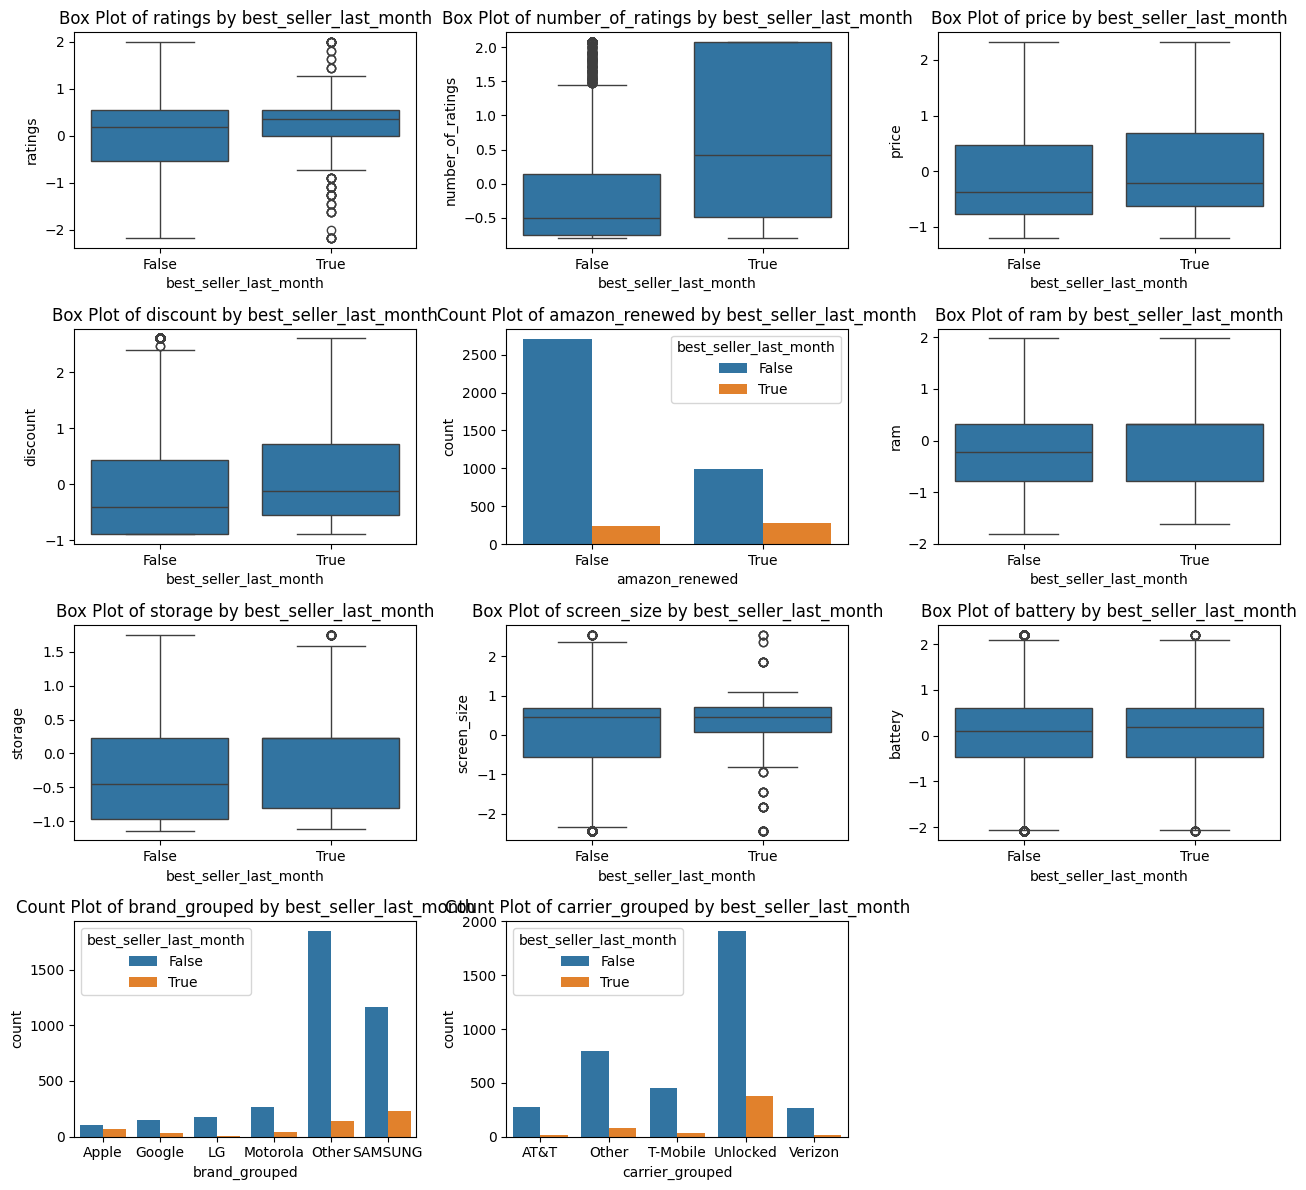

In [450]:
target_is_numeric = is_numeric_dtype(y) and not is_bool_dtype(y)
target_is_categorical = is_categorical_dtype(y)
target_is_boolean = is_bool_dtype(y)
target = "best_seller_last_month"

num_features = len(X.columns)
num_cols = 3
num_rows = (num_features + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(13, num_rows * 3))

for i, feature in enumerate(X.columns):
  row = i // num_cols
  col = i % num_cols
  ax = axes[row, col]

  feature_is_numeric = is_numeric_dtype(X[feature]) and not is_bool_dtype(X[feature])
  feature_is_boolean = is_bool_dtype(X[feature])
  feature_is_categorical = is_categorical_dtype(X[feature])

  if (target_is_categorical or target_is_boolean) and feature_is_numeric:
   sns.boxplot(x=y, y=X[feature], ax=ax)
   ax.set_title(f'Box Plot of {feature} by {target}')
  elif target_is_numeric and feature_is_numeric:
    sns.scatterplot(x=X[feature], y=y, ax=ax)
    ax.set_title(f'Scatter Plot of {feature} vs {target}')
  elif (target_is_categorical or target_is_boolean) and (feature_is_boolean
    or feature_is_categorical):
    sns.countplot(x=X[feature], hue=y, ax=ax)
    ax.set_title(f'Count Plot of {feature} by {target}')
  elif target_is_numeric and (feature_is_boolean or feature_is_categorical):
    sns.boxplot(x=X[feature], y=y, ax=ax)
    ax.set_title(f'Box Plot of {target} by {feature}')

for i in range(num_features, num_rows * num_cols):
  fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

In [451]:
X = pd.get_dummies(X, drop_first=True)

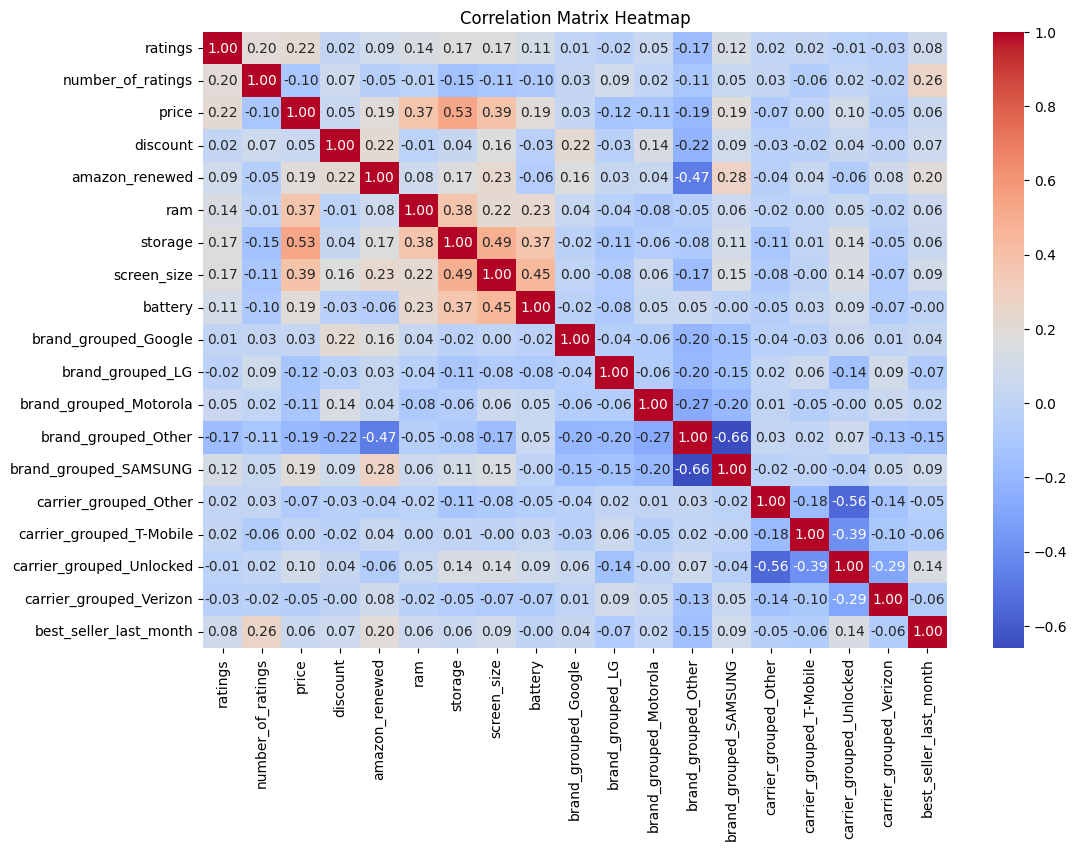

In [452]:
corr_matrix = pd.concat([X, y], axis=1).corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

In [453]:
X = X.drop(columns=['battery','screen_size','storage','ram','discount'])

**Splitting the data into training and testing sets**

In [454]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

**Train and test a Logistic Regression Model**

In [455]:
logreg_model = LogisticRegression(class_weight='balanced')
logreg_model.fit(X_train, y_train)

y_pred_logreg = logreg_model.predict(X_test)

print("=== Logistic Regression Results ===")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_logreg):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_logreg, average='macro'):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_logreg, average='macro'):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_logreg, average='macro'):.4f}")

logreg_coeff = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': logreg_model.coef_[0]
}).sort_values('Coefficient', ascending=False)
print("\nLogistic Regression Coefficients (Descending):\n", logreg_coeff)

=== Logistic Regression Results ===
Accuracy:  0.7476
Precision: 0.6138
Recall:    0.7225
F1 Score:  0.6201

Logistic Regression Coefficients (Descending):
                      Feature  Coefficient
11  carrier_grouped_Unlocked     1.455386
9      carrier_grouped_Other     0.862640
3             amazon_renewed     0.859573
10  carrier_grouped_T-Mobile     0.703064
1          number_of_ratings     0.648918
0                    ratings     0.142624
12   carrier_grouped_Verizon     0.127244
2                      price    -0.057196
6     brand_grouped_Motorola    -0.376169
8      brand_grouped_SAMSUNG    -0.511115
4       brand_grouped_Google    -0.547533
7        brand_grouped_Other    -0.887378
5           brand_grouped_LG    -3.066759


**Train and test a Random Forest Model**

In [456]:
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced')
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

print("\n=== Random Forest Results ===")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf, average='macro'):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_rf, average='macro'):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_rf, average='macro'):.4f}")

rf_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)
print("\nRandom Forest Feature Importances (Descending):\n", rf_importance)


=== Random Forest Results ===
Accuracy:  0.9100
Precision: 0.8262
Recall:    0.6979
F1 Score:  0.7405

Random Forest Feature Importances (Descending):
                      Feature  Importance
1          number_of_ratings    0.322276
2                      price    0.256329
0                    ratings    0.182033
3             amazon_renewed    0.055628
11  carrier_grouped_Unlocked    0.046972
7        brand_grouped_Other    0.037224
8      brand_grouped_SAMSUNG    0.017583
5           brand_grouped_LG    0.017391
9      carrier_grouped_Other    0.016206
10  carrier_grouped_T-Mobile    0.014527
6     brand_grouped_Motorola    0.014150
12   carrier_grouped_Verizon    0.009863
4       brand_grouped_Google    0.009818
